In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit.quantum_info import Statevector
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver, MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

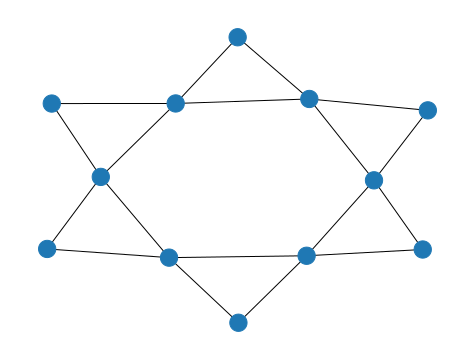

In [3]:
num_sites = 12
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
graph.add_edges_from(edge_list)
kagome_unit_cell = Lattice(graph)

kagome_unit_cell.draw()
plt.show()

In [4]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [5]:
exact_solver = ClassicalEigensolver(k=2)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues)

gs_energy = exact_result.eigenvalues[0]

[-18. -18.]


In [26]:
exact_result.eigenstates[0]

VectorStateFn(Statevector([ 3.30159735e-17-9.07795653e-22j,
             -6.62458973e-17+2.64716193e-17j,
             -6.64278328e-17+4.45856050e-17j, ...,
              2.40806793e-17-1.69335399e-17j,
             -5.98776360e-19-8.65500040e-18j,
              5.33095336e-17-7.96268289e-17j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)

In [17]:
# # GS0

# a = 0.137527629131423
# b = 0.123817626844876
# c = 0.013715078802222
# e_0 = 0.01147871869651
# e_1 = 0.01433809134044

# # (a, -e_0)        ==> +a
# # (b, -e_1)        ==> +b
# # (b, np.pi - e_1) ==> -b
# # (c, e_1)         ==> +c
# # (c, np.pi + e_1) ==> -c

# GS1

a = 0.12427869952314
b = 0.10651628806478
c = 0.01782824016325
e_0 = 0.03313096688
e_1 = 0.04643466759

# (a, e_0)         ==> +a
# (a, np.pi + e_0) ==> -a 
# (b, e_1)         ==> +b 
# (c, -e_1)        ==> +c
# (c, np.pi - e_1) ==> -c

In [10]:
a_states = []
b_plus_states = []
b_minus_states = []
c_plus_states = []
c_minus_states = []

test_sv = np.zeros(2**12)
for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    magnitude = np.abs(amplitude)
    phase = np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[252]) - e_1
    if np.isclose(magnitude, a):
        test_sv[index] = a
        a_states.append(index)
    if np.isclose(magnitude, b):
        if np.isclose(phase, -e_1):
            test_sv[index] = b
            b_plus_states.append(index)
        elif np.isclose(phase, np.pi - e_1):
            test_sv[index] = -b
            b_minus_states.append(index)
        else:
            raise RuntimeError()
    if np.isclose(magnitude, c):
        if np.isclose(phase, e_1):
            test_sv[index] = c
            c_plus_states.append(index)
        elif np.isclose(phase, np.pi + e_1):
            test_sv[index] = -c
            c_minus_states.append(index)
        else:
            raise RuntimeError()

test_sv

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
c_plus_states

[]

In [298]:
sv_string = ""

sv_string += f"{a}("
for state in a_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += f"+{b}("

sv_string += "("
for state in b_plus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += "-("
for state in b_minus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += ")"

sv_string += f"+{c}("

sv_string += "("
for state in c_plus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += "-("
for state in c_minus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += ")"

print(sv_string)

0.137527629131423(|000000111111\rangle+|111111000000\rangle)+0.123817626844876((|000011111100\rangle+|000101111010\rangle+|000110111001\rangle+|001001110110\rangle+|001010110101\rangle+|001100110011\rangle+|001111110000\rangle+|010001101110\rangle+|010010101101\rangle+|010100101011\rangle+|010111101000\rangle+|011000100111\rangle+|011011100100\rangle+|011101100010\rangle+|011110100001\rangle+|100001011110\rangle+|100010011101\rangle+|100100011011\rangle+|100111011000\rangle+|101000010111\rangle+|101011010100\rangle+|101101010010\rangle+|101110010001\rangle+|110000001111\rangle+|110011001100\rangle+|110101001010\rangle+|110110001001\rangle+|111001000110\rangle+|111010000101\rangle+|111100000011\rangle)-(|000001111110\rangle+|000010111101\rangle+|000100111011\rangle+|000111111000\rangle+|001000110111\rangle+|001011110100\rangle+|001101110010\rangle+|001110110001\rangle+|010000101111\rangle+|010011101100\rangle+|010101101010\rangle+|010110101001\rangle+|011001100110\rangle+|011010100101\r

In [18]:
a_plus_states = []
a_minus_states = []
b_states = []
c_plus_states = []
c_minus_states = []

test_sv = np.zeros(2**12)
for index, amplitude in enumerate(exact_result.eigenstates[1].primitive.data):
    magnitude = np.abs(amplitude)
    phase = np.angle(amplitude) - np.angle(exact_result.eigenstates[1].primitive.data[126]) - e_1
    if np.isclose(magnitude, a):
        if np.isclose(phase, e_0):
            test_sv[index] = a
            a_plus_states.append(index)
        elif np.isclose(phase, np.pi + e_0):
            test_sv[index] = -a
            a_minus_states.append(index)
        else:
            raise RuntimeError()
    if np.isclose(magnitude, b):
        test_sv[index] = b
        b_states.append(index)
    if np.isclose(magnitude, c):
        if np.isclose(phase, -e_1):
            test_sv[index] = c
            c_plus_states.append(index)
        elif np.isclose(phase, np.pi - e_1):
            test_sv[index] = -c
            c_minus_states.append(index)
        else:
            raise RuntimeError()

test_sv

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
exact_result.eigenstates[1].primitive.expectation_value(hamiltonian).real

-18.00000000000007

In [25]:
Statevector(test_sv).expectation_value(hamiltonian).real

0.0

In [327]:
sv_string = ""

sv_string += f"{a}("

sv_string += "("
for state in a_plus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += "-("
for state in a_minus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += ")"

sv_string += f"+{b}("
for state in b_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += f"+{c}("

sv_string += "("
for state in c_plus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += "-("
for state in c_minus_states:
    sv_string += f"|{state:0{num_sites}b}\\rangle+"
sv_string = sv_string[:-1] + ")"

sv_string += ")"

print(sv_string)

0.12427869952314((|000011111001\rangle+|000101110101\rangle+|000110110011\rangle+|001001101101\rangle+|001010101011\rangle+|001100100111\rangle+|001111100001\rangle+|010001011101\rangle+|010010011011\rangle+|010100010111\rangle+|010111010001\rangle+|011000001111\rangle+|011011001001\rangle+|011101000101\rangle+|011110000011\rangle+|100001111100\rangle+|100010111010\rangle+|100100110110\rangle+|100111110000\rangle+|101000101110\rangle+|101011101000\rangle+|101101100100\rangle+|101110100010\rangle+|110000011110\rangle+|110011011000\rangle+|110101010100\rangle+|110110010010\rangle+|111001001100\rangle+|111010001010\rangle+|111100000110\rangle)-(|000001111101\rangle+|000010111011\rangle+|000100110111\rangle+|000111110001\rangle+|001000101111\rangle+|001011101001\rangle+|001101100101\rangle+|001110100011\rangle+|010000011111\rangle+|010011011001\rangle+|010101010101\rangle+|010110010011\rangle+|011001001101\rangle+|011010001011\rangle+|011100000111\rangle+|011111000001\rangle+|100000111110\

In [315]:
for index, amplitude in enumerate(exact_result.eigenstates[1].primitive.data):
    if not np.isclose(np.abs(amplitude)**2, 0) and np.isclose(np.abs(amplitude), 0.12427869952314):
        print(f"({np.abs(amplitude)}, {np.angle(amplitude) - np.angle(exact_result.eigenstates[1].primitive.data[126]) - 0.09286933518/2}) |{index:0{num_sites}b}\\rangle ({index})")

(0.12427869952313672, 3.1747236204695386) |000001111101\rangle (125)
(0.12427869952313762, 3.1747236204695537) |000010111011\rangle (187)
(0.12427869952313668, 0.03313096687974463) |000011111001\rangle (249)
(0.12427869952313822, 3.1747236204695555) |000100110111\rangle (311)
(0.1242786995231372, 0.03313096687974985) |000101110101\rangle (373)
(0.12427869952313808, 0.03313096687976328) |000110110011\rangle (435)
(0.12427869952313755, 3.174723620469547) |000111110001\rangle (497)
(0.12427869952313633, 3.1747236204695377) |001000101111\rangle (559)
(0.12427869952313654, 0.03313096687974263) |001001101101\rangle (621)
(0.12427869952313719, 0.03313096687975329) |001010101011\rangle (683)
(0.12427869952313658, 3.174723620469536) |001011101001\rangle (745)
(0.12427869952313766, 0.03313096687975684) |001100100111\rangle (807)
(0.12427869952313694, 3.1747236204695413) |001101100101\rangle (869)
(0.12427869952313729, 3.1747236204695493) |001110100011\rangle (931)
(0.12427869952313687, 0.0331309

$$\alpha\left(|000000111111\rangle+|111111000000\rangle\right),\; \alpha\approx0.14e^{-2.46i}$$
$$\beta\left(\right),\;\beta\approx 0.12e^{0.68i}$$
$$\gamma\approx0.01e^{0.71i}$$

In [32]:
count = 0
for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if not np.isclose(np.abs(amplitude), 0):
        if np.isclose(np.abs(amplitude), 0.10698429461622003):
            if np.isclose(np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[126]), np.pi):
                count += 1
                print(f"|{index:0{num_sites}b}> ({index}): {np.abs(amplitude)}, {np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[126]):.2f}")
count

|000011111100> (252): 0.10698429461622018, 3.14
|000101111010> (378): 0.10698429461622028, 3.14
|000110111001> (441): 0.10698429461622037, 3.14
|001001110110> (630): 0.10698429461622011, 3.14
|001010110101> (693): 0.10698429461622018, 3.14
|001100110011> (819): 0.10698429461622025, 3.14
|001111110000> (1008): 0.10698429461622021, 3.14
|010001101110> (1134): 0.10698429461622017, 3.14
|010010101101> (1197): 0.10698429461622022, 3.14
|010100101011> (1323): 0.10698429461622043, 3.14
|010111101000> (1512): 0.10698429461622037, 3.14
|011000100111> (1575): 0.10698429461622064, 3.14
|011011100100> (1764): 0.10698429461622035, 3.14
|011101100010> (1890): 0.1069842946162203, 3.14
|011110100001> (1953): 0.10698429461622017, 3.14
|100001011110> (2142): 0.10698429461622018, 3.14
|100010011101> (2205): 0.10698429461622021, 3.14
|100100011011> (2331): 0.10698429461622036, 3.14
|100111011000> (2520): 0.1069842946162205, 3.14
|101000010111> (2583): 0.10698429461622042, 3.14
|101011010100> (2772): 0.106

30

In [67]:
print(np.abs(exact_result.eigenstates[0].primitive.inner(exact_result.eigenstates[0].primitive)) ** 2)
print(exact_result.eigenstates[0].primitive.expectation_value(hamiltonian).real)

1.0000000000000036
-18.000000000000043


In [110]:
inner_products = []
energies = []

for i in range(1, len(probability_to_states[0])):
    approximate_sv = np.zeros(2**12, dtype=np.cdouble)
    for state in probability_to_states[0][:i]:
        approximate_sv[state] = exact_result.eigenstates[0].primitive.data[state]
    approximate_sv = VectorStateFn(approximate_sv/np.linalg.norm(approximate_sv))

    inner_product = np.abs(approximate_sv.primitive.inner(exact_result.eigenstates[0].primitive)) ** 2
    inner_products.append(inner_product)

    energy = approximate_sv.primitive.expectation_value(hamiltonian).real
    energies.append(energy)

    # print(f"Inner product: {inner_product:.2f}")
    # print(f"Energy: {energy:.2f}")
    # print()

for i in range(1, len(probability_to_states[1])):
    approximate_sv = np.zeros(2**12, dtype=np.cdouble)
    for state in probability_to_states[0] + probability_to_states[1][:i]:
        approximate_sv[state] = exact_result.eigenstates[0].primitive.data[state]
    approximate_sv = VectorStateFn(approximate_sv/np.linalg.norm(approximate_sv))

    inner_product = np.abs(approximate_sv.primitive.inner(exact_result.eigenstates[0].primitive)) ** 2
    inner_products.append(inner_product)

    energy = approximate_sv.primitive.expectation_value(hamiltonian).real
    energies.append(energy)

    # print(f"Inner product: {inner_product:.2f}")
    # print(f"Energy: {energy:.2f}")
    # print()

for i in range(1, len(probability_to_states[2])):
    approximate_sv = np.zeros(2**12, dtype=np.cdouble)
    for state in probability_to_states[0] + probability_to_states[1] + probability_to_states[2][:i]:
        approximate_sv[state] = exact_result.eigenstates[0].primitive.data[state]
    approximate_sv = VectorStateFn(approximate_sv/np.linalg.norm(approximate_sv))

    inner_product = np.abs(approximate_sv.primitive.inner(exact_result.eigenstates[0].primitive)) ** 2
    inner_products.append(inner_product)

    energy = approximate_sv.primitive.expectation_value(hamiltonian).real
    energies.append(energy)

    # print(f"Inner product: {inner_product:.2f}")
    # print(f"Energy: {energy:.2f}")
    # print()

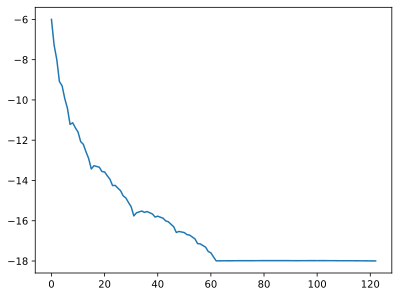

In [111]:
plt.plot(range(len(energies)), energies)
plt.show()

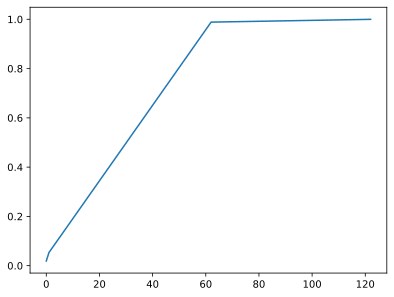

In [112]:
plt.plot(range(len(energies)), inner_products)
plt.show()

In [164]:
approximate_sv = np.zeros(2**12, dtype=np.cdouble)
for state in probability_to_states[1]:
    approximate_sv[state] = exact_result.eigenstates[0].primitive.data[state]
approximate_sv = VectorStateFn(approximate_sv/np.linalg.norm(approximate_sv))

inner_product = np.abs(approximate_sv.primitive.inner(exact_result.eigenstates[0].primitive)) ** 2
energy = approximate_sv.primitive.expectation_value(hamiltonian).real

print(f"Inner product: {inner_product:.2f}")
print(f"Energy: {energy:.2f}")

Inner product: 0.95
Energy: -17.61


In [36]:
probability_values = [np.abs(statevector.primitive.data[63]) ** 2, np.abs(statevector.primitive.data[126]) ** 2, np.abs(statevector.primitive.data[125]) ** 2]
probability_values

In [109]:
index = 0
statevector = exact_result.eigenstates[index]

states = [f"{state:0{num_sites}b}" for state in range(2**num_sites)]
amplitudes = [ statevector.primitive.data[state] for state in range(2**num_sites) ]
probabilities = [ np.abs(statevector.primitive.data[state]) ** 2 for state in range(2**num_sites) ]

present_states = []
present_state_amplitudes = []
present_state_probabilities = []

probability_to_states = [[], [], []]
for probability_index, value in enumerate(probability_values):
    print(f"\tProbability: {value:.4f}")
    print(f"\tProbability: {value:.4f}")
    for state_index, (state, probability) in enumerate(zip(states, probabilities)):
        if np.isclose(probability, value):
            present_states.append(f"$|{state}\\rangle$")
            present_state_probabilities.append(probability)
            probability_to_states[probability_index].append(state_index)
            print(f"\t\t|{state}> ({state_index})")

    print()

# plt.figure(figsize=(300, 225))
# plt.bar(present_states, present_state_probabilities)
# plt.xlabel("State")
# plt.ylabel("Probability")
# plt.title(f"Ground State #{index} Probability Distribution")
# plt.show()

print()

Probabilities
	Probability: 0.0189
		|000000111111> (63)
		|111111000000> (4032)

	Probability: 0.0153
		|000001111110> (126)
		|000010111101> (189)
		|000011111100> (252)
		|000100111011> (315)
		|000101111010> (378)
		|000110111001> (441)
		|000111111000> (504)
		|001000110111> (567)
		|001001110110> (630)
		|001010110101> (693)
		|001011110100> (756)
		|001100110011> (819)
		|001101110010> (882)
		|001110110001> (945)
		|001111110000> (1008)
		|010000101111> (1071)
		|010001101110> (1134)
		|010010101101> (1197)
		|010011101100> (1260)
		|010100101011> (1323)
		|010101101010> (1386)
		|010110101001> (1449)
		|010111101000> (1512)
		|011000100111> (1575)
		|011001100110> (1638)
		|011010100101> (1701)
		|011011100100> (1764)
		|011100100011> (1827)
		|011101100010> (1890)
		|011110100001> (1953)
		|011111100000> (2016)
		|100000011111> (2079)
		|100001011110> (2142)
		|100010011101> (2205)
		|100011011100> (2268)
		|100100011011> (2331)
		|100101011010> (2394)
		|100110011001> (2457)

In [126]:
0.12381762684487581**2

0.01533080471749691

In [125]:

for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if np.isclose(np.abs(amplitude)**2, probability_values[1]):
        sign = np.exp(1j * (np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[252]))).real.astype(int)
        print(f"{'+' if sign > 0 else '-'}{np.abs(amplitude)}|{index:0{num_sites}b}\\rangle")

-0.12381762684487581|000001111110\rangle
-0.12381762684487607|000010111101\rangle
+0.12381762684487593|000011111100\rangle
-0.12381762684487597|000100111011\rangle
+0.12381762684487592|000101111010\rangle
+0.123817626844876|000110111001\rangle
-0.12381762684487592|000111111000\rangle
-0.12381762684487571|001000110111\rangle
+0.12381762684487566|001001110110\rangle
+0.12381762684487582|001010110101\rangle
-0.12381762684487564|001011110100\rangle
+0.12381762684487582|001100110011\rangle
-0.12381762684487575|001101110010\rangle
-0.12381762684487588|001110110001\rangle
+0.12381762684487574|001111110000\rangle
-0.12381762684487595|010000101111\rangle
+0.12381762684487577|010001101110\rangle
+0.12381762684487585|010010101101\rangle
-0.12381762684487592|010011101100\rangle
+0.12381762684487584|010100101011\rangle
-0.12381762684487582|010101101010\rangle
-0.12381762684487596|010110101001\rangle
+0.12381762684487595|010111101000\rangle
+0.12381762684487595|011000100111\rangle
-0.123817626844875

In [133]:
sv_string = f"$\\frac1{{\sqrt{{{len(probability_to_states[1])}}}}}("
for index, amplitude in enumerate(exact_result.eigenstates[0].primitive.data):
    if np.isclose(np.abs(amplitude)**2, probability_values[1]):
        sign = np.exp(1j * (np.angle(amplitude) - np.angle(exact_result.eigenstates[0].primitive.data[252]))).real.astype(int)
        sv_string += f" {'+' if sign > 0 else '-'} |{index:0{num_sites}b}\\rangle"
sv_string += ")$"
print(sv_string)

$\frac1{\sqrt{62}}( - |000001111110\rangle - |000010111101\rangle + |000011111100\rangle - |000100111011\rangle + |000101111010\rangle + |000110111001\rangle - |000111111000\rangle - |001000110111\rangle + |001001110110\rangle + |001010110101\rangle - |001011110100\rangle + |001100110011\rangle - |001101110010\rangle - |001110110001\rangle + |001111110000\rangle - |010000101111\rangle + |010001101110\rangle + |010010101101\rangle - |010011101100\rangle + |010100101011\rangle - |010101101010\rangle - |010110101001\rangle + |010111101000\rangle + |011000100111\rangle - |011001100110\rangle - |011010100101\rangle + |011011100100\rangle - |011100100011\rangle + |011101100010\rangle + |011110100001\rangle - |011111100000\rangle - |100000011111\rangle + |100001011110\rangle + |100010011101\rangle - |100011011100\rangle + |100100011011\rangle - |100101011010\rangle - |100110011001\rangle + |100111011000\rangle + |101000010111\rangle - |101001010110\rangle - |101010010101\rangle + |10101101010

In [147]:
for state_index in probability_to_states[1][:31]:
    configuration = f"{state_index:0{num_sites}b}"
    if "1"*3 in configuration and not "1"*4 in configuration and not "1"*6 in configuration:
        print(configuration)

000100111011
000110111001
001000110111
001001110110
001101110010
001110110001
010001101110
010011101100
011000100111
011011100100
011100100011
011101100010


In [ ]:
# 111111 cycled through start indices from 1 to 10
# 000001111110
# 000011111100
# 000111111000
# 001111110000
# 011111100000



# 10111101 cycled through start indices from 1 to 10
# 010000101111

# 000010111101
# 000101111010
# 001011110100
# 010111101000

# 011110100001



# 100111011 cycled
# 011000100111


# 000100111011
# 001001110110
# 010011101100
# 001110110001
# 011101100010



# 001000110111
# 010001101110

# 000110111001
# 001101110010
# 011011100100


# 011100100011


In [ ]:
# prepare 6 adjacent 1s cycled through all indices

# prepare 1 cycled through all indices (bell state)
01
10

# prepare 2 adjacents 1s cycled through all indices
0011
0110
1100
1001

0011 + 1100
0110 + 1001

In [168]:
int("1001", 2)

9

In [163]:
circuit = QuantumCircuit(4)

# circuit.h(0)
# circuit.cx(0, 1)
# circuit.cx(0, 2)
# circuit.cx(0, 3)
# circuit.x(2)
# circuit.x(3)

# circuit.h(0)
# circuit.cx(0, 1)
# circuit.cx(0, 2)
# circuit.cx(0, 3)
# circuit.x(1)
# circuit.x(2)

circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.cx(0, 3)

circuit.x(1)
circuit.h(2)
circuit.x(3)

Statevector(circuit).draw("latex")

<IPython.core.display.Latex object>